In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 读取（下载）MNIST数据集

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='../datasets/mnist', train=True, download=True, transform=transform)  # download=True:如果没有下载数据集
test_dataset = datasets.MNIST(root='../datasets/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

In [25]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 展示MNIST数据集

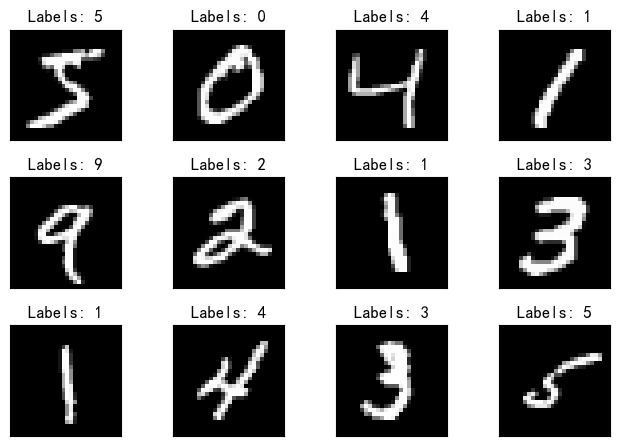

In [26]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


### 构建简单的CNN网络

In [27]:
class Net(torch.nn.Module):
    def __init__(self):
        # （batch,1,28,28）
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3), #（batch,32,26,26） 输入通道数1输出通道数32 32为小型任务的经验性选择，一般每层增加一倍欠拟合就加过拟合减
            torch.nn.BatchNorm2d(32), # 对卷积层的输出进行批量归一化，使得每个特征图的分布更加稳定，从而加速训练并提高模型性能。
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,32,13,13）
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3), #（batch,64,11,11）
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,64,5,5）
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1600, 50), # 1600 == 64*5*5
            torch.nn.ReLU(),  # 添加ReLU激活函数 增加模型的非线性能力
            torch.nn.Dropout(0.5), # 有效防止过拟合-丢弃率0.5          BN层和dropout层一起用效果不好（ 深层可能不好BN在后Dropout在前也不好
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [28]:
model = Net().to(device)

# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)
模型总参数数量: 99,568
模型可训练参数数量: 99,568


### 训练模型

In [29]:
loss_fn    = torch.nn.CrossEntropyLoss() # 交叉熵损失函数，常用在多分类任务中
learn_rate = 0.01 # 学习率
optimizer  = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum = 0.9)

In [ ]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [31]:
def test(dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

### 开始训练

In [32]:
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_loader, model, loss_fn, optimizer)

    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_loader, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)

    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))

tensor([8, 5, 1, 6, 1, 0, 4, 0, 0, 2, 2, 2, 7, 5, 1, 5, 1, 4, 3, 5, 4, 4, 2, 7,
        7, 7, 0, 3, 5, 9, 0, 5])
tensor([2, 1, 3, 1, 0, 7, 2, 6, 6, 7, 9, 8, 8, 8, 6, 7, 9, 8, 9, 3, 1, 2, 1, 9,
        2, 1, 4, 8, 6, 8, 7, 5])
tensor([3, 3, 0, 1, 4, 4, 7, 0, 3, 1, 6, 8, 4, 7, 1, 4, 5, 7, 1, 8, 0, 7, 1, 3,
        0, 6, 3, 8, 0, 3, 9, 5])
tensor([9, 0, 0, 6, 7, 0, 2, 9, 3, 0, 9, 6, 4, 3, 9, 3, 0, 8, 1, 6, 9, 0, 6, 0,
        5, 2, 7, 3, 9, 0, 4, 6])
tensor([3, 5, 8, 7, 9, 6, 5, 6, 8, 9, 2, 7, 9, 4, 7, 6, 6, 7, 2, 6, 9, 1, 6, 7,
        6, 1, 5, 7, 3, 5, 2, 2])
tensor([1, 5, 5, 9, 5, 8, 9, 9, 0, 2, 0, 7, 1, 8, 9, 5, 9, 7, 4, 6, 3, 9, 4, 2,
        2, 5, 9, 7, 5, 0, 9, 2])
tensor([6, 0, 3, 0, 6, 5, 7, 3, 4, 5, 0, 0, 9, 4, 2, 5, 6, 0, 3, 7, 0, 9, 8, 1,
        8, 9, 7, 1, 0, 0, 5, 3])
tensor([6, 1, 1, 6, 2, 8, 2, 8, 6, 9, 8, 7, 9, 0, 6, 0, 2, 0, 7, 3, 7, 1, 5, 8,
        2, 8, 9, 4, 8, 9, 5, 5])
tensor([4, 4, 9, 7, 7, 4, 3, 5, 3, 3, 6, 2, 5, 6, 4, 8, 8, 6, 1, 3, 1, 9, 6, 1,
        8, 6, 8,

KeyboardInterrupt: 

###  结果可视化

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 保存模型

In [ ]:
# 指定保存路径
save_dir = '../models/1_Handwritten_Digit_Recognition'

# 确保目录存在，如果不存在则创建
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(model.state_dict(), os.path.join(save_dir, 'model_weights.pth'))

# # 加载模型参数
# model.load(torch.load(os.path.join(save_dir, 'model_weights.pth')))